# Machine Learning Pipelines

# Models as a task graph (DAG)
<img src="../part_1/img/rolson17-ml-pipeline.png">
<div style="text-align: right">Source: R. Olson et. al. (2017) "Data-driven Advice for Applying Machine Learning to Bioinformatics Problems."</div>

# Why a DAG?

### Encapsulation

Feature engineering operators, post-processing (e.g. calibration) are part of your model.

### Optimization

Feature engineering operators have hyper-parameters too. Furthermore, we want to search over graphs.

### Safety

Ensure that no information from testing can "leak" into the model fitting phase.

### Train-test-skew

Contracts between operators are more subtle than just message schemas; assumptions about the data distribution are included as well. Operators must not change after the model was fit!

# Pipelines in Scikit-learn

### [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline)

A linear sequence of `Estimator` objects that represent a fixed set of steps, often feature extraction, normalization and classification. It implements the [Composite design pattern (GoF)](https://en.wikipedia.org/wiki/Composite_pattern).

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a `transform` method).

Pipelines allow nested parameters:
```python

est = Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])
est.set_params(scaler__with_std=False)
```

### Exercise

Build a `Pipeline` version of the `PolynomialRegressor` and search for the optimal `degree` of the polynomial.

In [3]:
%run ../part_1/utils.py

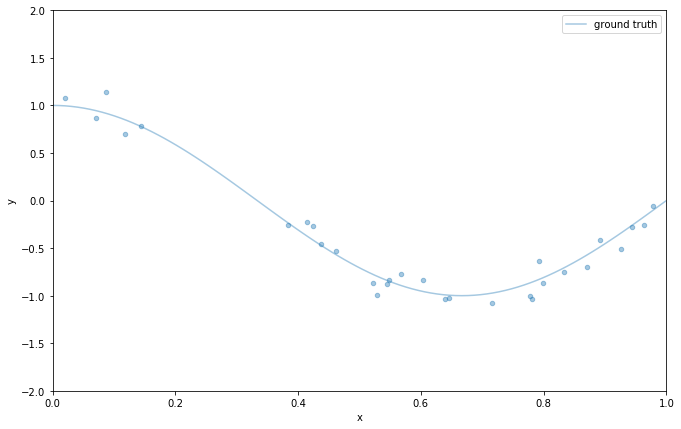

In [5]:
X, y = generate_curve_data()
fig = plot_data(X, y, fn=true_fn)

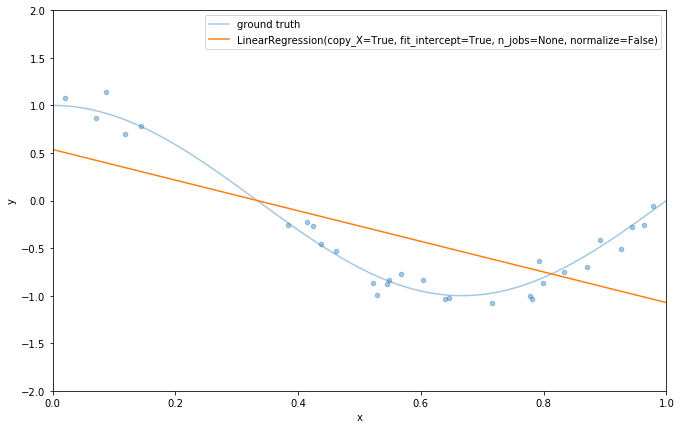

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

est = LinearRegression()

gs = GridSearchCV(estimator=est, param_grid={}, 
                  scoring='neg_mean_squared_error', cv=3)

## Solution
#est = Pipeline(steps=[('poly', PolynomialFeatures()), ('lr', LinearRegression())])
#
#gs = GridSearchCV(estimator=est, param_grid={'poly__degree': range(1, 20)}, 
#                  scoring='neg_mean_squared_error', cv=3)

gs.fit(X[:, np.newaxis], y)

fig = plot_data(X, y, fn=true_fn)
plot_estimator(gs.best_estimator_, fig)

# Beyond a chain of estimators


### [FeatureUnion](https://scikit-learn.org/stable/modules/compose.html#featureunion-composite-feature-spaces)

Combines several transformer objects into a new transformer that combines their output.
Takes a list of transformer objects, each of which is fit to the data independently. 
The transformers are applied in parallel, and the feature matrices they output are concatenated side-by-side into a wider matrix (via `np.hstack`).

```python
feature_extractors = [('poly', PolynomialFeatures()), ('pca', PCA())]
est = Pipeline(steps=[('fu_1', FeatureUnion(feature_extractors)), 
                      ('rfe', RFE(LinearRegression(), 5, step=1)), 
                      ('lr', LinearRegression())])
```

### Caching of transformers

Pipelines can do [caching](https://scikit-learn.org/stable/modules/compose.html#caching-transformers-avoid-repeated-computation) via `memory` which helps to avoid repeated computation. 

TODO Column Transformer

# Exercise

### Task

Build the ML pipeline below on the Fastiron dataset; use default hyper-parameter settings.

### Dataset

[Blue Book for Bulldozers (aka Fastiron) Kaggle competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data). 

Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.